<a href="https://colab.research.google.com/github/HauwaUmar/DATA-6100/blob/main/final_submission_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary

The aim of this project is to predict house prices for residential homes in Ames, Iowa. Linear Regression was used to estimate the house prices. 79 explanatory variables were provided as features to make this prediction that gave details about each house. Both numerical and non-numerical data types were provided as features. We were provided with a training and testing dataset to implement our model on

**Numerical columns**

Examples of numerical columns provides are:
```
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
Fireplaces: Number of fireplaces
GarageArea: Size of garage in square feet
````
**Non-numerical columns**

Other columns contained categorical data i.e. ordinal and nominal data 

Example of columns with nominal data:
```
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
```
Examples of columns with ordinal data:
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement
```

After exploring the data set, I made some observations:
- Some columns had a significant amount of missing data with up to 50% of their rows missing data, these columns were dropped.
- The non-numeric columns contained either nominal or ordinal data types. Columns with nominal datatypes were transposed while columns with ordinal datatypes that contain information in their ordering set were transformed to numbers using a label encoder.

After the data preprocessing and transformation I was left with 236 features to work it. I split the dataset back to the train and dateset originally provided and ran a linear regression with all the features.
The model did okay after doing a cross validation which is basically a library used to ensure all observations are used for both testing and training of a model. It got an average score of 84%.

While going through the models summary I noticed some columns had lower signifance in the model and decided to run a backward elimination method to removed variables that were the least significant.

After the feature selection process, 107 features were returned which means 129 columns were removed from the dataset.

I ran another model with the 107 variables and ran a cross validation on the new model and it improved by 2%, from 84% to 86%. That's not a big improvement but it is something.




## Kaggle Score

In [41]:
from google.colab import files
from IPython.display import Image

In [42]:
uploaded = files.upload()

Saving kaggle_score.png to kaggle_score.png


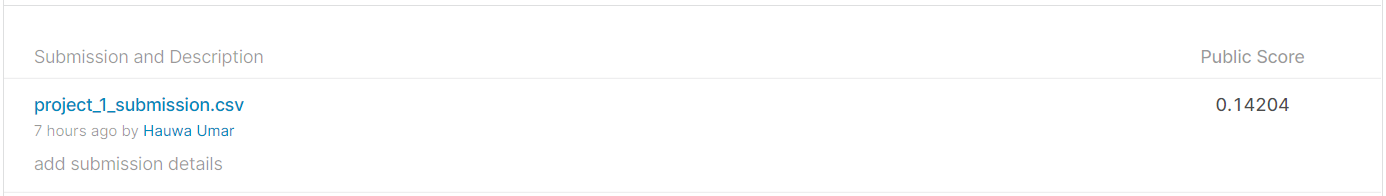

In [43]:
Image('kaggle_score.png')

# Detailed Result

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm, skew #for some statistics
from sklearn.model_selection import KFold, cross_val_score #for cross validation
pd.set_option('display.min_rows', 4)

In [2]:
train_dataset = pd.read_csv("train.csv")
true_test_dataset = pd.read_csv("test.csv")

#check the numbers of samples and features
print("The train data size: {} ".format(train_dataset.shape))
print("The test data size: {} ".format(true_test_dataset.shape))

The train data size: (1460, 81) 
The test data size: (1459, 80) 


In [3]:
display(train_dataset)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [4]:
# combine both testing and training dataset for transformation
whole_dataset = pd.concat((train_dataset, true_test_dataset)).reset_index(drop = True)

print("\nThe whole data size before dropping Id feature is : {} ".format(whole_dataset.shape)) 
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
whole_dataset.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe whole data size after dropping Id feature is : {} ".format(whole_dataset.shape)) 



The whole data size before dropping Id feature is : (2919, 81) 

The whole data size after dropping Id feature is : (2919, 80) 


## Data Preprocessing

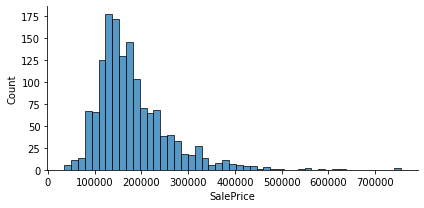

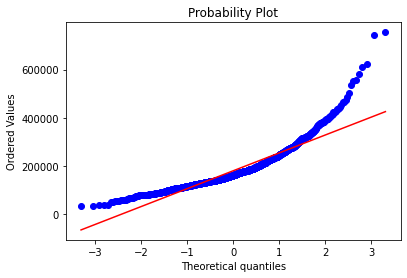

In [5]:
# checking the distribution for the target
sns.displot(train_dataset['SalePrice'], height=3, aspect=2)


#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_dataset['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


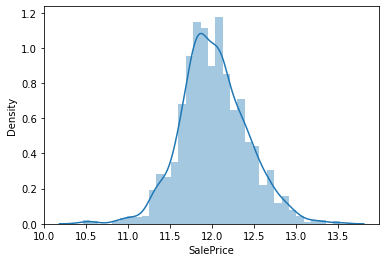

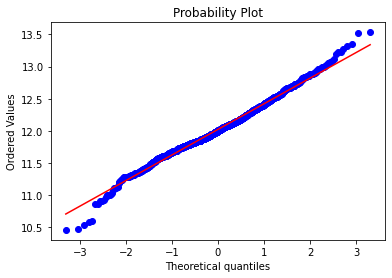

In [6]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_dataset["SalePrice"] = np.log1p(train_dataset["SalePrice"])

#Check the new distribution 
sns.distplot(train_dataset['SalePrice']);

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_dataset['SalePrice'], plot=plt)
plt.show()

The data now looks better i.e. it looks more normally distributed.

### Handling missing data


Remember we concatenated thr train and test data set to a dataframe called "whole_dataset". We will use that for our data cleaning so both datasets can be aligned

In [7]:
# this function will go through the data frame and return information on columns with missing values such as the number of missing data in each column and the percentage of missing value overall for each column
def info_on_missing_values(df):
    total_missing_values = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percentage = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    data_type = df.dtypes.sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    decription_of_missing_values = pd.concat([total_missing_values, percentage, data_type], axis=1, keys=['Total Missing Val','Percentage','Data Type'])
    return decription_of_missing_values

info_on_missing_values(whole_dataset)[:10]

,Total Missing Val,Percentage,Data Type
PoolQC,2909,99.66,object
MiscFeature,2814,96.40,object
Alley,2721,93.22,object
Fence,2348,80.44,object
SalePrice,1459,49.98,float64
FireplaceQu,1420,48.65,object
LotFrontage,486,16.65,float64
GarageCond,159,5.45,object
GarageFinish,159,5.45,object
GarageQual,159,5.45,object


Text(0.5, 1.0, 'Percentage of missing data by variable')

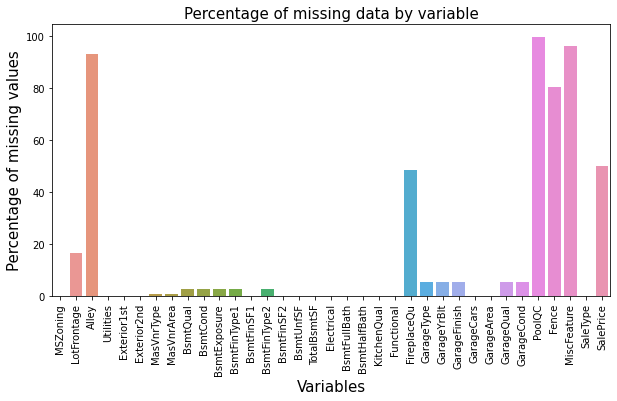

In [8]:
# plotting a bar chart to show the percentage of missing values in each column with missing values 
col = whole_dataset.columns[whole_dataset.isna().any().to_list()]
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='90')
sns.barplot(x=col, y=(whole_dataset[col].isnull().sum().values)/len(whole_dataset)*100)
plt.xlabel('Variables', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing data by variable', fontsize=15)

Some columns have a very high percentage of missing values and are most probably insignifcant to our models. We will drop them. Also SalePrice has half missing because the test dataset has no sale price. We will handle that as well.

In [9]:
# dropping columns with less than 2000 rows of data 
whole_dataset = whole_dataset.dropna(axis=1,thresh=2000)

info_on_missing_values(whole_dataset) 

,Total Missing Val,Percentage,Data Type
LotFrontage,486,16.65,float64
GarageQual,159,5.45,object
GarageYrBlt,159,5.45,float64
GarageFinish,159,5.45,object
GarageCond,159,5.45,object
GarageType,157,5.38,object
BsmtExposure,82,2.81,object
BsmtCond,82,2.81,object
BsmtQual,81,2.77,object
BsmtFinType2,80,2.74,object


The columns with high missing values hvae been dropped

Some columns have only 4 missing values or less. We'll fill those missing columns with 0's or None depending on the data type of the column 

In [10]:
from pandas.core.internals.blocks import missing
# making a list of columns with missing values
missing_val_cols = whole_dataset.columns[whole_dataset.isna().any()]
# filling columns with missing values less than 5 with 0 or None
for col in missing_val_cols:
    if whole_dataset[col].isnull().sum() <5:
        if whole_dataset[col].dtype == 'object':
            whole_dataset[col]= whole_dataset[col].fillna('None')
        else:
            whole_dataset[col] = whole_dataset[col].fillna(0)


# making a new list of columns with missing values 
missing_val_cols_2 = whole_dataset.columns[whole_dataset.isna().any()]
missing_val_cols_2

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')

#### Analysing each column with missing data 

We have a list of columns left with missing data now we go throught them individually to decide what method to fill them with is the best 

In [11]:
# FOR LOTFRONTAGE
whole_dataset['LotFrontage'].describe()
# no column has significant correlation with LotFrontage
# assigning mean value to miss value for LotFrontage
whole_dataset['LotFrontage'] = whole_dataset['LotFrontage'].fillna(whole_dataset['LotFrontage'].mean())


In [12]:
# for MasVnrType
whole_dataset['MasVnrType'].describe()
# none has the most frequency. i will use that to fill the missing data. 
whole_dataset['MasVnrType']= whole_dataset['MasVnrType'].fillna(whole_dataset['MasVnrType'].mode()[0])

In [13]:
# for MasVnrArea
whole_dataset['MasVnrArea'].describe()
#assigning mode to MasVnrArea
whole_dataset['MasVnrArea']= whole_dataset['MasVnrArea'].fillna(whole_dataset['MasVnrArea'].mode()[0])

In [14]:
#for GarageYrBlt
whole_dataset['GarageYrBlt'].describe()
# Chekcing which column has most correlation with GarageYrBlt column
# looking for correlation between gyb and other collumns

#print(whole_dataset.corr()['GarageYrBlt'].nlargest(3))
# There is significant coorelation between YearBuilt and GarageYrBlt 
# dropping GarageYrBlt         
whole_dataset = whole_dataset.drop(['GarageYrBlt'],axis = 1)

In [15]:
# for BsmtExposure
whole_dataset['BsmtExposure'].describe()
# filling with mode 
whole_dataset['BsmtExposure']= whole_dataset['BsmtExposure'].fillna(whole_dataset['BsmtExposure'].mode()[0])

Some columns do not have missing values. They represent none as "NA". 

**Example of Column with such description**

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement

We will replace NA with none

In [16]:
# FOR BsmtQual
whole_dataset['BsmtQual'].describe()
# I WILL FILL WITH NONE BECAUSE ACCORDING TO THE DATA SET DESCRIPTION NA MEANS NONE
whole_dataset['BsmtQual']= whole_dataset['BsmtQual'].fillna('None')

# For BsmtCond
whole_dataset['BsmtCond'].describe()
# I WILL FILL WITH NONE BECAUSE ACCORDING TO THE DATA SET DESCRIPTION NA MEANS NONE
whole_dataset['BsmtCond']= whole_dataset['BsmtCond'].fillna('None')


#for BsmtFinType1
whole_dataset['BsmtFinType1'].describe()
# I WILL FILL WITH NONE BECAUSE ACCORDING TO THE DATA SET DESCRIPTION NA MEANS NONE
whole_dataset['BsmtFinType1']= whole_dataset['BsmtFinType1'].fillna('None')

# for BsmtFinType2
whole_dataset['BsmtFinType2'].describe()
# I WILL FILL WITH NONE BECAUSE ACCORDING TO THE DATA SET DESCRIPTION NA MEANS NONE
whole_dataset['BsmtFinType2']= whole_dataset['BsmtFinType2'].fillna('None')


# for GarageType
whole_dataset['GarageType'].describe()
# I WILL FILL WITH NONE BECAUSE ACCORDING TO THE DATA SET DESCRIPTION NA MEANS NONE
whole_dataset['GarageType']= whole_dataset['GarageType'].fillna('None')



# for GarageFinish
# I WILL FILL WITH NONE BECAUSE ACCORDING TO THE DATA SET DESCRIPTION NA MEANS NONE
whole_dataset['GarageFinish']= whole_dataset['GarageFinish'].fillna('None')


# for GarageQual
# I WILL FILL WITH NONE BECAUSE ACCORDING TO THE DATA SET DESCRIPTION NA MEANS NONE
whole_dataset['GarageQual']= whole_dataset['GarageQual'].fillna('None')


# for GarageCond
# I WILL FILL WITH NONE BECAUSE ACCORDING TO THE DATA SET DESCRIPTION NA MEANS NONE
whole_dataset['GarageCond']= whole_dataset['GarageCond'].fillna('None')

In [17]:
# checking for columns with missing values
info_on_missing_values(whole_dataset)

,Total Missing Val,Percentage,Data Type


HURRAY WE HAVE HANDLED ALL THE COLUMNS WITH MISSING VALUES

### Handling numerical columns

One assumption for linear regression is that variables are independent. We will go through the dataset and check for columns that have high correlation

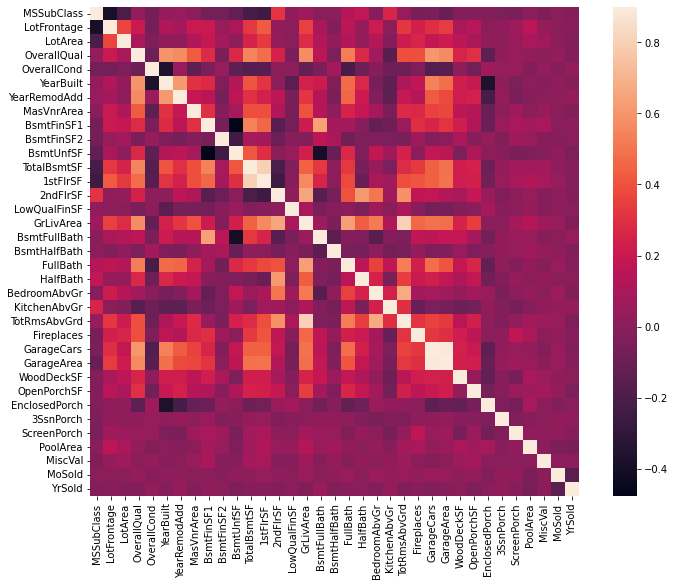

In [18]:
#Correlation map to see how features are correlated with each other
corrmat = whole_dataset.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

The plot isn't really helpful. We will create a correlation matrix instead and deduce the column with high correlation



In [19]:
# Create correlation matrix
corr_matrix = whole_dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85 and put them in a list
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
#whole_dataset.drop(to_drop,axis=1)
to_drop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


['GarageArea']

In [20]:
# checking column that has high correlation with Garage Area
whole_dataset.corr()['GarageArea'].nlargest(3)

GarageArea     1.000000
GarageCars     0.889890
OverallQual    0.565179
Name: GarageArea, dtype: float64

This shows that Garage Area and Garage Cars have a high correlation

```
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

```
From the description we can see most times the garage area and the size of garage in car capacity are either the same or as the car size space increases the garage area increases as well

In [21]:
# dropping garage cars
whole_dataset = whole_dataset.drop('GarageCars',axis=1)

### Handling non-numerical columns

There are columns with categorical data which need to be worked on before inserting into the model.

After going through the data description, Some columns have ordinal data and others have nominal data.

**Nominal Data**
```
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
````
**Ordinal Data**
```
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

```

I have gone through the data description and created a list of columns with nonimal ordinal data

#### Nominal data

In [22]:
# This is a list of columns with nominal data 
categorical_columns = ['MSZoning','Street','LotShape','LandContour',
'Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
'Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
'Exterior2nd','MasVnrType','Foundation','Heating','CentralAir',
'Electrical','Functional','GarageType','GarageFinish','PavedDrive','SaleType','SaleCondition']


# for categorical data the goal is to transpose the dataset for each category of each column and attach binary values 
whole_dataset = pd.get_dummies(whole_dataset, prefix=categorical_columns, columns=categorical_columns)
whole_dataset.shape

(2919, 236)

#### Ordinal data


In [23]:

# This is a list of columns with ordinal data
ordinal_columns = ['OverallQual','OverallCond','ExterQual','ExterCond',
'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
'HeatingQC','KitchenQual','GarageCond','GarageQual']

# for columns with ordinal data, the solution is to use a label encoder to attach numbers to each level
# the label encoder object
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in ordinal_columns:
    whole_dataset[col]=le.fit_transform(whole_dataset[col])

whole_dataset.dtype="object"

All columns with object data types have been changed to numeric values

## Modelling

We are going to use a linear regression to build this model

### First Model

Remember we combined both test and train dataset for data processing, we will split them for our modelling

In [24]:
# spilt the dataset into the original train and test set again
true_train_dataset = whole_dataset[:1460] 
 
true_test_dataset = whole_dataset[1460:] 

# assigning the target variable to Y
Y = train_dataset['SalePrice']


In [31]:
# Running linear regression using all the variables
model = LinearRegression()

print("Running Linear Regression using all variables...")


model.fit(true_train_dataset, Y)

list_of_col = true_train_dataset.columns.to_list()


print("")
# using cross validation to check the accuracy of the model
k_folds = KFold(n_splits = 4)

scores = cross_val_score(model, true_train_dataset, Y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

print("")

data_coef = pd.Series(index=list_of_col, data=model.coef_)

coef_order = data_coef.abs().sort_values(ascending=False).index.tolist()

        
print('-------Top 10 Features with high estimates ---------')
print(data_coef[coef_order][:10])

Running Linear Regression using all variables...

Cross Validation Scores:  [0.89017747 0.87450465 0.8608101  0.77844365]
Average CV Score:  0.8509839658563594
Number of CV Scores used in Average:  4

-------Top 10 Features with high estimates ---------
RoofMatl_ClyTile   -2.441109
Condition2_PosN    -0.716871
RoofMatl_Membran    0.637558
RoofMatl_Metal      0.455063
Condition2_PosA     0.373428
RoofMatl_WdShngl    0.369435
Condition2_RRAe    -0.368398
RoofStyle_Shed      0.343327
MSZoning_C (all)   -0.334841
RoofMatl_Roll       0.285220
dtype: float64


The model is doing terrible :(

After using all the features the model did poorly and because we have a lot of features we would need to choose only the features that actually help us with predicting our target.

### Feature Selection

I am using backward elimination method. We use all the features to the model then remove the worst performing feature using the p_value untill the performance of the model is good.




Step 1 of backward elimination 

In [32]:
# checking the max p_value from the first model with all the features

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(true_train_dataset)
#Fitting sm.OLS model
model_ols = sm.OLS(Y,X_1).fit()
t = pd.DataFrame()
t['pvalue'] = model_ols.pvalues
t[t['pvalue'] == max(t['pvalue'])]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,pvalue
Exterior2nd_Other,0.861116


The next step is to drop the column and rerun the model without that column

In [33]:
# This loop reiterates through the dataset and drops columns with high p_values until the model is good 
#Backward Elimination
features = list(true_train_dataset.columns)
pmax = 1
while (len(features)>0):
    verbose = False
    p= []
    X_1 = true_train_dataset[features]
    X_1 = sm.add_constant(X_1)
    model3 = sm.OLS(Y,X_1).fit()
    p = pd.Series(model3.pvalues.values[1:],index = features)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        features.remove(feature_with_p_max)
    else:
        break

# list of selected features using backward elimation        
selected_features_BE = features

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versi

We have a list of features we believe should give us a better prediction after using the backward elimination method

In [34]:
# number of s
print("Number of Features:{}".format(len(selected_features_BE)))

Number of Features:107


In [35]:
# Our loop selected 107 features to use to get a better model

### Creating a new test and train dataset with the columns choosen using backward elimination
new_train_dataset = true_train_dataset[selected_features_BE]
new_test_dataset = true_test_dataset[selected_features_BE]


# creating model
model4 = LinearRegression()

# fitting the model
model4.fit(new_train_dataset, Y)

list_of_col = new_train_dataset.columns.to_list()


### Final Model Accuracy

We need to check how well our model is doing. We are aiming to increase overall model performance on unseen data. We use cross validation to know how well our model is doing.

In [36]:
# using CV score to cross validate our model by splitting the data set into 10 for testing
k_folds = KFold(n_splits = 5)

scores = cross_val_score(model4, new_train_dataset, Y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.90932208 0.8851838  0.86722982 0.92693638 0.73293369]
Average CV Score:  0.8643211561833025
Number of CV Scores used in Average:  5


In [ ]:
X2 = sm.add_constant(new_train_dataset)
est = sm.OLS(Y, X2)
est2 = est.fit()
est2.pvalues[0:10]

This model is doing better compared to our first model 

Creating a residual plot to check how well the model worked on training dataser

In [ ]:
# using the model to predict from the train dataset
y_pred = model4.predict(new_train_dataset)

#calculating the residual which is the actual value minus the predicted value
residuals = Y-y_pred

# creating a residual plot 
plt.scatter(y = residuals,x = y_pred)

plt.show()

From the residual plot, the points are close to zero which is good. However the points do not have constant variance which means our model can be improved.

In [ ]:
data_coef = pd.Series(index=list_of_col, data=model4.coef_)

coef_order = data_coef.abs().sort_values(ascending=False).index.tolist()

print("----- Coefficients in Linear Regressions -------")
for i in range(0,len(new_train_dataset.columns)-1):
    if model4.coef_[i] == 0:
        print("{}:{}".format(list_of_col[i],model4.coef_[i]))
        
print('-------Top 10 Features with high estimates ---------')
print(data_coef[coef_order][:10])

### Running Model on Kaggle test dataset

In [ ]:
# predicting numbers for kaggle test dataset
y_pred = model4.predict(new_test_dataset)

# setting predictions into data frame as in kaggle's sample submission
submission=pd.DataFrame()
submission['SalePrice']=np.exp(y_pred) # the sale price was logged in the beggining so we have to transform it back
submission = submission.reset_index()
submission = submission.rename(columns={"index":"Id"})
submission['Id'] = submission.index + len(submission)+2

# loading the data frame to csv files for submission
submission.to_csv('project_1_submission.csv',index=False)
  

# Interpretation of model

## Number of variables


In our final model, we've been able to improve our model by using only 107 variables instead of using all 236 variables. This suggests that the variables which were ommited such as if the Exterior covering on house is classified as other did not seem to help predict the house price.


## Coefficient Interpretation

-------Top 10 Features with high estimates ---------
* RoofMatl_ClyTile:-      -2.496388
* Condition2_PosN :-      -0.862393
* RoofMatl_Membran:-      0.600497
* RoofMatl_Metal:-        0.478032
* MSZoning_RH:-         0.418199
* MSZoning_FV:-        0.412944
* MSZoning_RL:-         0.410313
* MSZoning_RM:-        0.354843
* RoofMatl_WdShngl:-    0.326137
* Functional_Typ:-      0.307409


According to the coefficients gotten from the model,
  1. Roof materials
    - a house whose roof is made with clytile clay or tile reduce the price of a house.
   - a house with roof is made of Membrane or Metal increase the price of the house.
  2. Proximity to various conditions (if more than one is present)
    - Houses near positive off-site feature--park, greenbelt, etc reduce the price of house.
  3. MS Zoning
    - Houses in Floating Village(FV), Low Density(RL) and Medium Density(RM) increases the price of a house.
  




#### Description of the top features


MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

	RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

 Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	

## Conclusion on model



Our final model is doing better than the first model. Going through the residual plot the model is doing good, however it can be improved by maybe tranforming some variables.